# Grid Cell Phase Coding 

Phases are in radians, coordinates are in [m] and time base is [ms].
The first data point in XYspkT corresponds with the first spike, which also corresponds with the first phase value and so on. So those files should have the same number of rows and if you merge them as columns each row should correspond with the same spike event.
So here is an important detail to pay attention to. __Because the spike times in the file are not in an ascending order but in the order of cells combined (like cell1 t1, cell1 t2, cell1 t3,..., cell2 t1, cell2 t2, cell2 t3,...)  if you sort them you will need to reindex the XYspkT and Phase data too.__
Or you just leave them as they are. Then they remain aligned.
 
The ultimate task is to predict the place where the avatar goes next based on the phase of the next spike. We have all the info we need. We know where the avatar is in space (X,Y), we know the phase of the next spike and we know the average map of all phases. We just need to find where the next spike would best fit on that map of opportunities based on average phases. Because average phases tessellate like grids, therefore for a given spike phase there are multiple spots in the field where that spike can ideally land. Of course the real landing spot is  one that is nearby, since the avatar does not jump. So we need to look the map of average phases at the local neighborhood and find the best match between the actual phase and the average phase map. The vector between the avatar's actual position and the predicted position (i.e the position where the phase of next spike would best match) defines a vector of moving direction. These are the small arrows in my plot.

An example:  
Let say the spike that just happened at t0 was generated at 30 degree (0.5236 rad) of the ongoing gamma cycle. We know the avatar's spatial position (X,Y). We also know that next spike t1 will be generated at 45 degree but we don't know at what spatial position. So we are considering the next 6 spikes (where 6 is an arbitrary number)  or a 5 x 5 m area around the spike (where 5 is an arbitrary metric) and try to find a tile with the average phase that best fit to the phase of next spike. That tile would be our best guess for the next position of the avatar.

Of course, for a cross-validation purpose, we will need to divide the data into a training set and decoding set (or predicting set). That will be the second step. But for start, let's just try to decode the phase using the entire 5 min data.

### add firing map

### pay critical attention to whether coordinates in numpy [-y,x] or Cartesian [x,y]

In [91]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fuckit

#%matplotlib inline
np.set_printoptions(suppress=True)
%config InLineBackend.figure_format = 'retina'

## XYspktT

XYspktT contains the X,Y coordinates of spikes. Spikes from all 30 neurons are combined in a single spike train. The X and Y columns represent the avatar's X-Y coordinate in [m] relative to the environment at the moment of the spike. 

[[ 9 22]
 [ 9 22]
 [27 23]
 ...
 [ 9 21]
 [27 23]
 [28 23]]


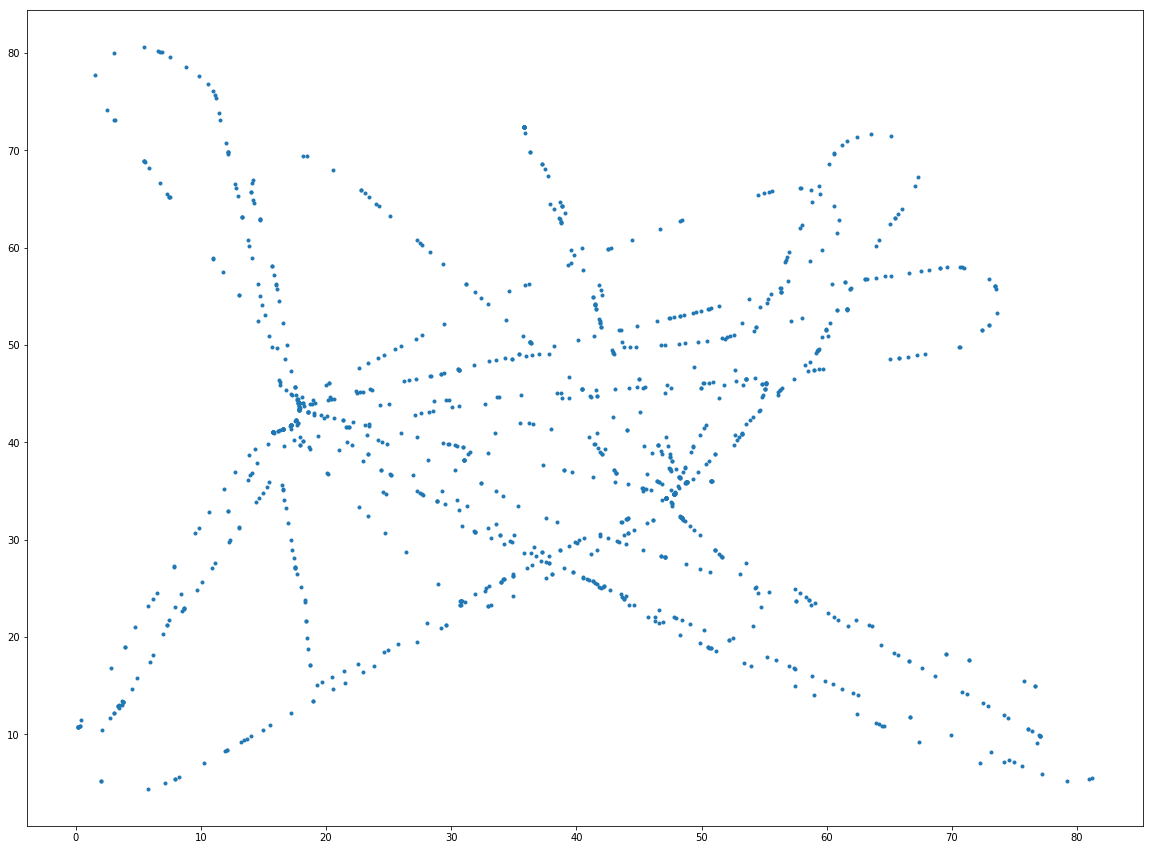

In [92]:
XYspkT = np.loadtxt('XYspkT.csv',delimiter=',')+40
scaled_XY = np.round(XYspkT/2).astype(int)
print(scaled_XY)
#2x2 meter bin

plt.plot(XYspkT[:,0],XYspkT[:,1],'.')
#plt.plot(scaled_XY[:,0],scaled_XY[:,1],'.')

## spkT

spkT contains the times of the spikes in ms

In [93]:
spkT = np.loadtxt('spkT.csv',delimiter=',')
print(spkT)
spkT.shape

[ 27466.  29501.  36602. ... 288400. 295600. 297440.]


(1178,)

## Phase

Phase is the corresponding (gamma) phase of the spikes - what phase the gamma oscillation was at them moment of spike

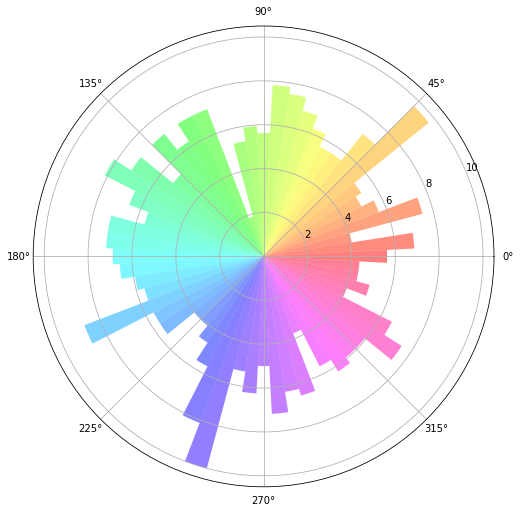

In [94]:
phase = np.loadtxt('Phase.csv',delimiter=',')
scaled_phase = phase-3.14

phase_degrees = np.degrees(phase)
sorted_phase = np.sort(phase_degrees)


#Radial histogram of phase distribution
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
theta = np.radians(np.arange(0,366,6))

inds = [np.where(sorted_phase<i)[0][-1] for i in np.arange(6,366,6)] #vectorize operation?
b = np.split(sorted_phase,inds)
radii = np.array([i.size/3.2 for i in b])

width = np.radians(360/60)
bars = ax.bar(theta, radii, width=width, bottom=0.0)
for theta, bar in zip(theta, bars):
    bar.set_facecolor(plt.cm.hsv(theta/6.28))
    bar.set_alpha(0.5)

plt.show()

## MeanPhaseMap

MeanPhaseMap the map of gamma phases. This is a 40x43 matrix that represents the 80x86 m land of the desert, the area covered by the avatar's navigation. The lot of NaN data correspond with areas never visited. A given value at the n-th row and m-th column represents the average phase of spikes (all spikes) within that area during the entire 5 min navigation. 

TODO:

-(time based meanphasemap of first half, traj from second)

-average internode distance

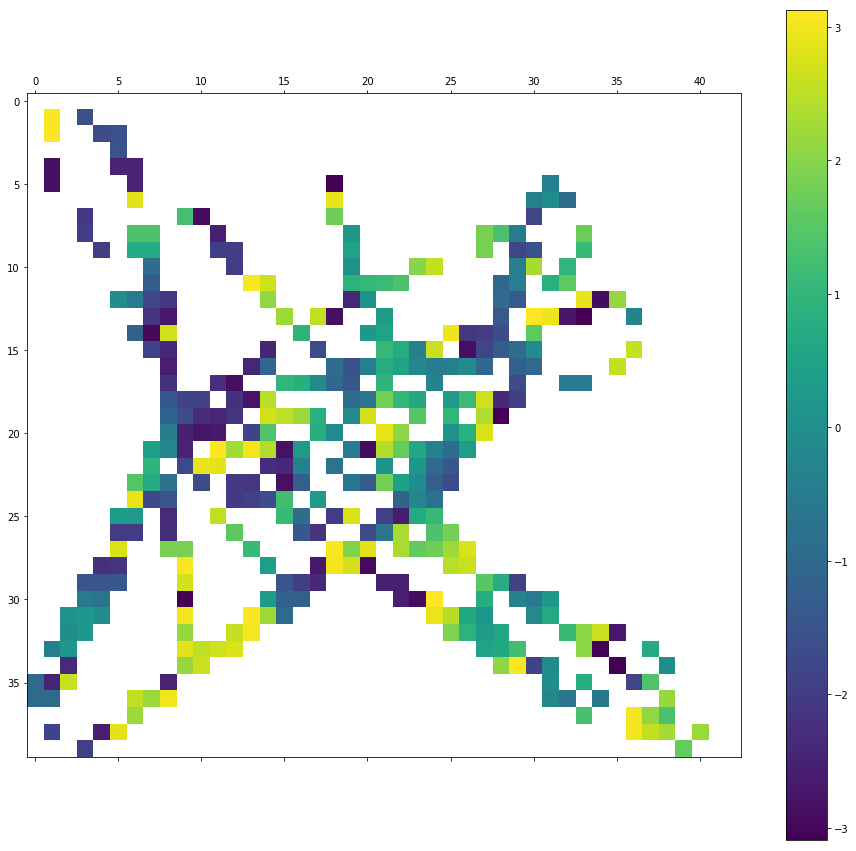

In [95]:
raw = np.loadtxt('MeanPhaseMap.csv',delimiter=',')

#Flipping to match the other plots
MeanPhaseMap = np.flip(raw,axis=0)
MeanPhaseMap/np.pi
plt.matshow(MeanPhaseMap)

#Reflect radians in bar
plt.colorbar()

## Binned Phase Map

In [96]:
def remove_singles(array):
    has_neighbor = np.zeros(array.shape, bool)
    has_neighbor[:, 1:] = np.logical_or(has_neighbor[:, 1:], array[:, :-1] > 0)  # left
    has_neighbor[:, :-1] = np.logical_or(has_neighbor[:, :-1], array[:, 1:] > 0)  # right
    has_neighbor[1:, :] = np.logical_or(has_neighbor[1:, :], array[:-1, :] > 0)  # above
    has_neighbor[:-1, :] = np.logical_or(has_neighbor[:-1, :], array[1:, :] > 0)  # below

    array[np.logical_not(has_neighbor)] = 0
    return array

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


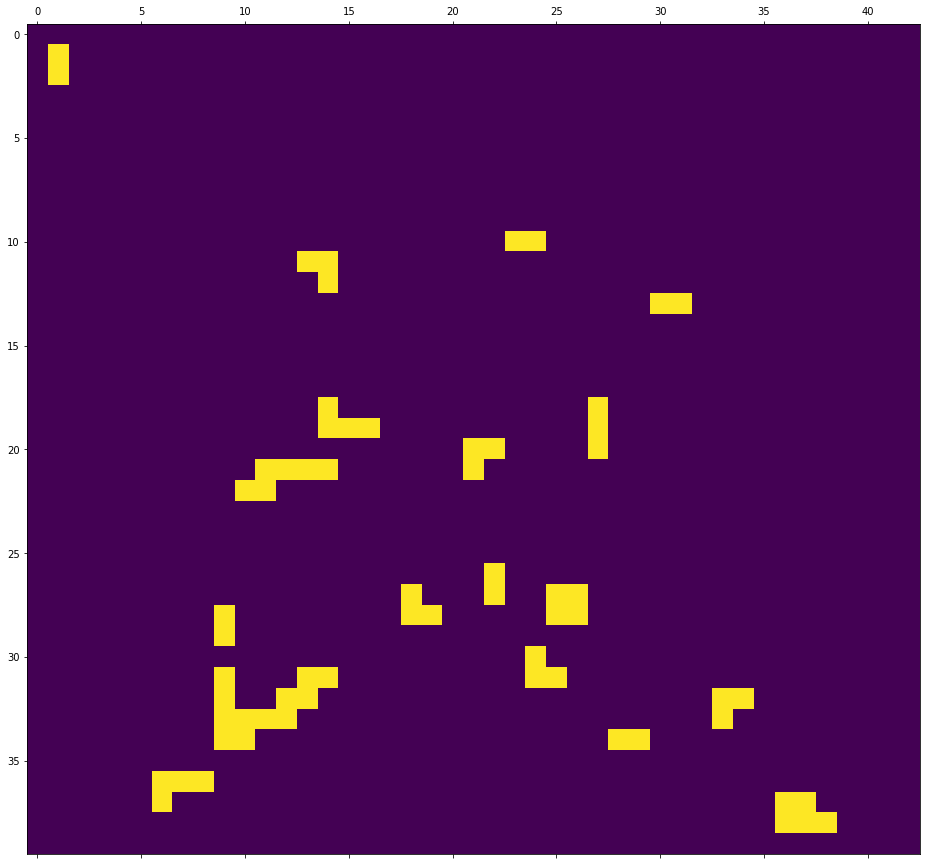

In [97]:
MPM3 = (MeanPhaseMap>2)*1
filtered_MPM3 = remove_singles(MPM3)
plt.matshow(filtered_MPM3)

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


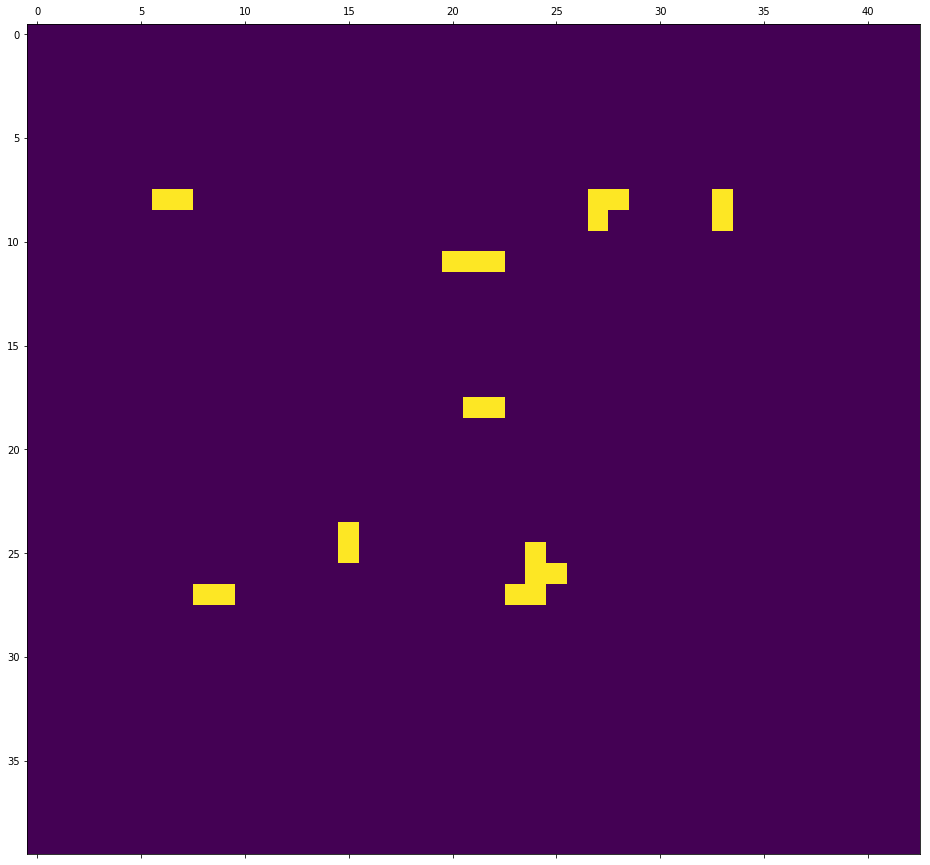

In [98]:
MPM2 = ((MeanPhaseMap>1) & (MeanPhaseMap<2))*1
filtered_MPM2 = remove_singles(MPM2)
plt.matshow(filtered_MPM2)

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


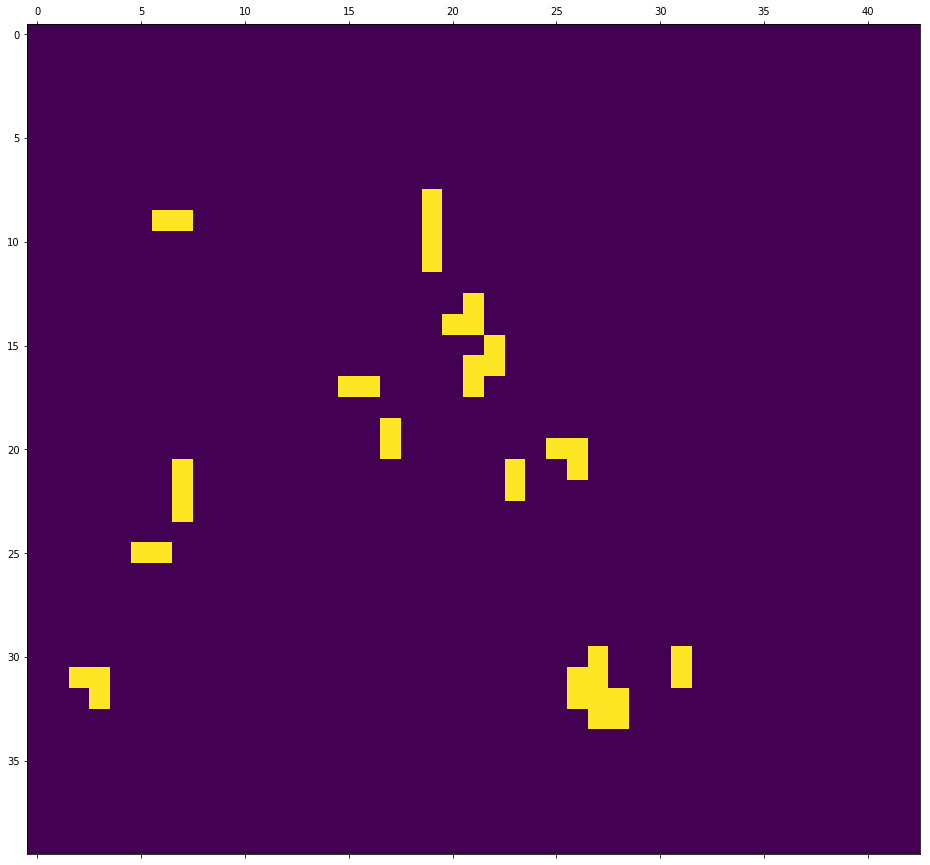

In [99]:
MPM1 = ((MeanPhaseMap>0) & (MeanPhaseMap<1))*1
filtered_MPM1 = remove_singles(MPM1)
plt.matshow(filtered_MPM1)

## xyPos
xyPos is the trajectory traveled by the avatar. Each row is an X-Y data pair in [m] sampled in every ms. It is the biggest file because of the density of points. You can down-sample it to make it more manageable.

[[31.0183  38.1906 ]
 [31.0183  38.1906 ]
 [31.0183  38.1906 ]
 ...
 [52.56    39.68139]
 [52.502   39.57129]
 [52.443   39.46164]]


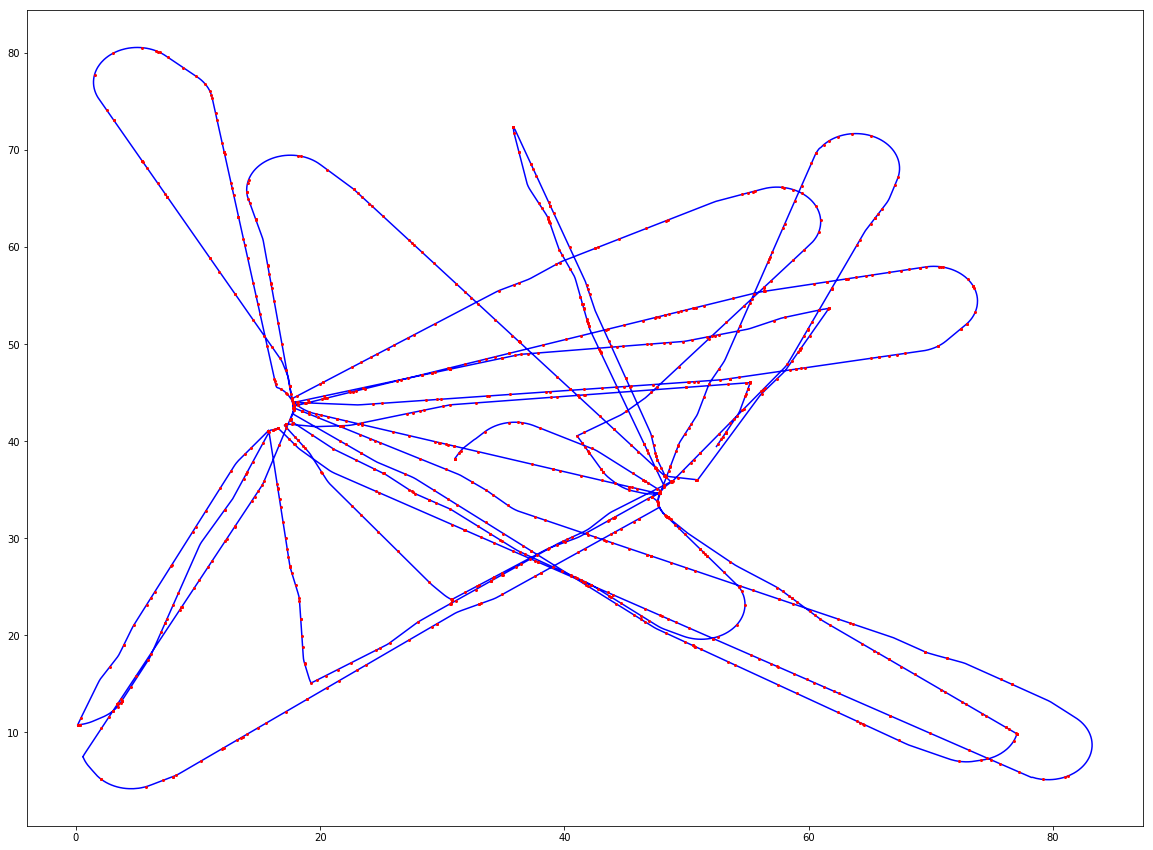

In [100]:
xyPos = np.loadtxt('xyPos.csv',delimiter=',')[::25]+40
print(xyPos)

#Trajectory overlaid with XYspkT
plt.plot(xyPos[:,0],xyPos[:,1], color='b')
plt.plot(XYspkT[:,0],XYspkT[:,1], '.', color='r', markersize=4)

## MeanPhaseMap DataFrame


In [101]:
phase_df = pd.DataFrame(data=MeanPhaseMap, columns=np.arange(43))
phase_df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,3.0844,NaN,-1.5684,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3.0844,NaN,NaN,-1.6837,-1.5763,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,-1.5088,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,-2.8458,NaN,NaN,NaN,-2.5082,-2.5082,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
padded_phase_map = np.pad(MeanPhaseMap,pad_width=4,mode='constant',constant_values=np.nan)
padded_phase_df = pd.DataFrame(data=padded_phase_map, columns=np.arange(51))

#edge case of 40 - scaling issue?

### Adjacent Matrix Function

Returns a 5x5 array to analyze a region of space adjacent to a target location within the MeanPhaseMap, then finds
the x and y difference from the center to cell to the cell with the cloest matching value (of phase).

example return array:

       [ 3.0844,     nan, -1.5684,     nan,     nan],

       [ 3.0844,     nan,     nan, -1.6837, -1.5763],
       
       [    nan,     nan,     nan,     nan, -1.5088],
       
       [-2.8458,     nan,     nan,     nan, -2.5082],
       
       [-2.8458,     nan,     nan,     nan,     nan]

In [103]:
def adjacent_matrix(cell):
    cell = list(map(int, cell))
    c_x = cell[0]
    c_y = cell[1]
    a = padded_phase_df.iloc[44-c_y-4:44-c_y+3,c_x+1:c_x+8]
    
    return a
    

def nearest_phase(array,phase):
    
    #Determines change vector from central cell
    #to cell nearest in value in 7x7 IN FORM **[X,Y]**
        
    am = np.nanargmin(np.abs(array-phase))
    loc = [(am%7)-3,3-(am//7)]
    return loc

    
def phase_from_movement(array, x, y):
    
    try:
        return array.iloc[3-y,3+x]
    except:
        #return array[3,3]
        pass
#Tests:
print(adjacent_matrix([16,19]))
#print(nearest_phase(adjacent_matrix([16,19]),-2.4))
print(phase_from_movement(adjacent_matrix([16,19]),0,0))

        17      18       19       20       21        22        23
21     NaN     NaN  0.99545  0.82617 -0.13557 -1.002400 -1.388400
22 -2.7783  2.4835      NaN      NaN      NaN       NaN -0.905500
23     NaN  2.7104  2.53100  2.19120  0.84319       NaN -0.095368
24 -1.8151  1.4106      NaN      NaN  0.80192 -0.082343       NaN
25  3.0041  2.4122 -2.80850  0.28660      NaN       NaN -0.554390
26     NaN -2.2952 -2.40350 -0.36067      NaN -0.735160       NaN
27 -2.1202     NaN -2.82100 -1.21920      NaN       NaN -0.667790
nan


## Combined Position, Time and Phase DataFrame

X,Y position, change in distance, time and phase data sorted by trajectory from the Time column in a dataframe

In [104]:
unsorted = np.column_stack((spkT,scaled_XY,scaled_phase))
combined = unsorted[unsorted[:,0].argsort()]

next_phase = np.insert(combined[1:,3],-1, 0)

xdif = np.append(combined[1:,1],0)-np.append(combined[:-1,1],0)
ydif = np.append(combined[1:,2],0)-np.append(combined[:-1,2],0)

almost_all = np.column_stack((combined,next_phase,xdif,ydif))
almost_all


array([[    16.    ,     16.    ,     19.    , ...,      1.9293,
             0.    ,      0.    ],
       [   127.    ,     16.    ,     19.    , ...,      2.8428,
             0.    ,      0.    ],
       [   133.    ,     16.    ,     19.    , ...,      0.7757,
             0.    ,      0.    ],
       ...,
       [298520.    ,     26.    ,     20.    , ...,      3.14  ,
             0.    ,      0.    ],
       [298580.    ,     26.    ,     20.    , ...,      0.    ,
             0.    ,      0.    ],
       [298690.    ,     26.    ,     20.    , ...,      1.7533,
             0.    ,      0.    ]])

In [105]:
predicted_movement = np.asarray([nearest_phase(adjacent_matrix([i[1],i[2]]),i[4]) for i in almost_all])
actual_phase = np.asarray([phase_from_movement(adjacent_matrix(i[1:3]),int(i[5]),int(i[6])) for i in almost_all])

all=np.column_stack((almost_all,predicted_movement, actual_phase))
df = pd.DataFrame(data=all, columns=['Time','X','Y','Phase','Next Phase','Xdif','Ydif','Xdif Predicted', 'Ydif Predicted','Actual Phase'])

df.head()

,Time,X,Y,Phase,Next Phase,Xdif,Ydif,Xdif Predicted,Ydif Predicted,Actual Phase
0,16,16,19,1.4839,1.9293,0,0,0,1,NaN
1,127,16,19,1.9293,2.8428,0,0,-2,1,NaN
2,133,16,19,2.8428,0.7757,0,0,1,0,NaN
3,161,16,19,0.7757,2.9106,0,0,-3,-1,NaN
4,275,16,19,2.9106,-1.0658,0,0,2,3,NaN


In [106]:
df_move = df.where((df['Xdif'] > 0) | (df['Ydif'] > 0)).dropna(subset=['Xdif'])
df_move

,Time,X,Y,Phase,Next Phase,Xdif,Ydif,Xdif Predicted,Ydif Predicted,Actual Phase
6,907,16,19,0.0088,-2.40195,1,1,-1,-2,0.84319
7,1495,17,20,-2.40195,-1.6251,1,1,2,3,NaN
10,2157,18,21,-1.6001,-2.99536,1,0,2,-3,-0.9055
11,2473,19,21,-2.99536,-0.0644,2,-1,-1,-2,NaN
12,3432,21,20,-0.0644,-2.97689,2,-2,-1,-2,0.60639
18,4574,23,18,-0.5967,-2.18499,1,-1,2,-2,-0.97593
28,7114,23,17,1.0932,-2.49696,-1,1,-1,-3,1.6573
32,7681,22,18,-3.03876,-3.05637,0,1,-2,0,2.0755
36,8378,21,19,-1.7305,-0.0505,0,1,2,-3,NaN
42,10154,21,20,2.3196,-0.8742,2,2,-3,3,NaN


In [107]:
fake = df_move.where((df_move['Xdif']==df_move['Xdif Predicted']) | (df_move['Ydif']==df_move['Ydif Predicted'])).dropna(subset=['Xdif'])
fake.head()

,Time,X,Y,Phase,Next Phase,Xdif,Ydif,Xdif Predicted,Ydif Predicted,Actual Phase
12,3432,21,20,-0.0644,-2.97689,2,-2,-1,-2,0.60639
28,7114,23,17,1.0932,-2.49696,-1,1,-1,-3,1.6573
43,10970,23,22,-0.8742,-0.4655,1,1,1,1,-0.49036
45,11665,24,23,-1.6139,-3.05918,1,1,2,1,NaN
46,12228,25,24,-3.05918,-3.00791,1,1,1,0,-2.0946


In [108]:
def vector_angles(df):
    
    angles = []
    for index, row in df.iterrows():
        p0 = [row['Xdif'],row['Ydif']]
        p1 = [0,0]
        p2 = [row['Xdif Predicted'],row['Ydif Predicted']]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        angles.append(np.abs(np.degrees(atan)))
        
    return angles

In [109]:
vector_angles(df_move)

[161.565051177078,
 11.309932474020213,
 56.309932474020215,
 90.0,
 71.56505117707799,
 0.0,
 116.56505117707799,
 90.0,
 146.30993247402023,
 90.0,
 0.0,
 18.43494882292201,
 45.0,
 161.565051177078,
 90.0,
 135.0,
 146.30993247402023,
 101.30993247402021,
 161.565051177078,
 180.0,
 90.0,
 135.0,
 108.43494882292201,
 56.309932474020215,
 33.690067525979785,
 33.690067525979785,
 108.43494882292202,
 135.0,
 71.56505117707799,
 123.69006752597979,
 123.6900675259798,
 161.565051177078,
 18.43494882292201,
 90.0,
 45.0,
 18.43494882292201,
 150.25511870305778,
 45.0,
 135.0,
 180.0,
 18.43494882292201,
 153.434948822922,
 0.0,
 0.0,
 90.0,
 11.309932474020217,
 116.56505117707799,
 45.00000000000001,
 135.0,
 108.43494882292201,
 45.0,
 135.0,
 135.0,
 180.0,
 90.0,
 168.6900675259798,
 45.00000000000001,
 26.565051177077994,
 90.0,
 90.0,
 101.30993247402021,
 71.56505117707799,
 26.56505117707799,
 82.8749836510982,
 18.43494882292201,
 63.43494882292201,
 101.30993247402021,
 146.

In [110]:
np.mean(vector_angles(df_move))

92.09249755523838

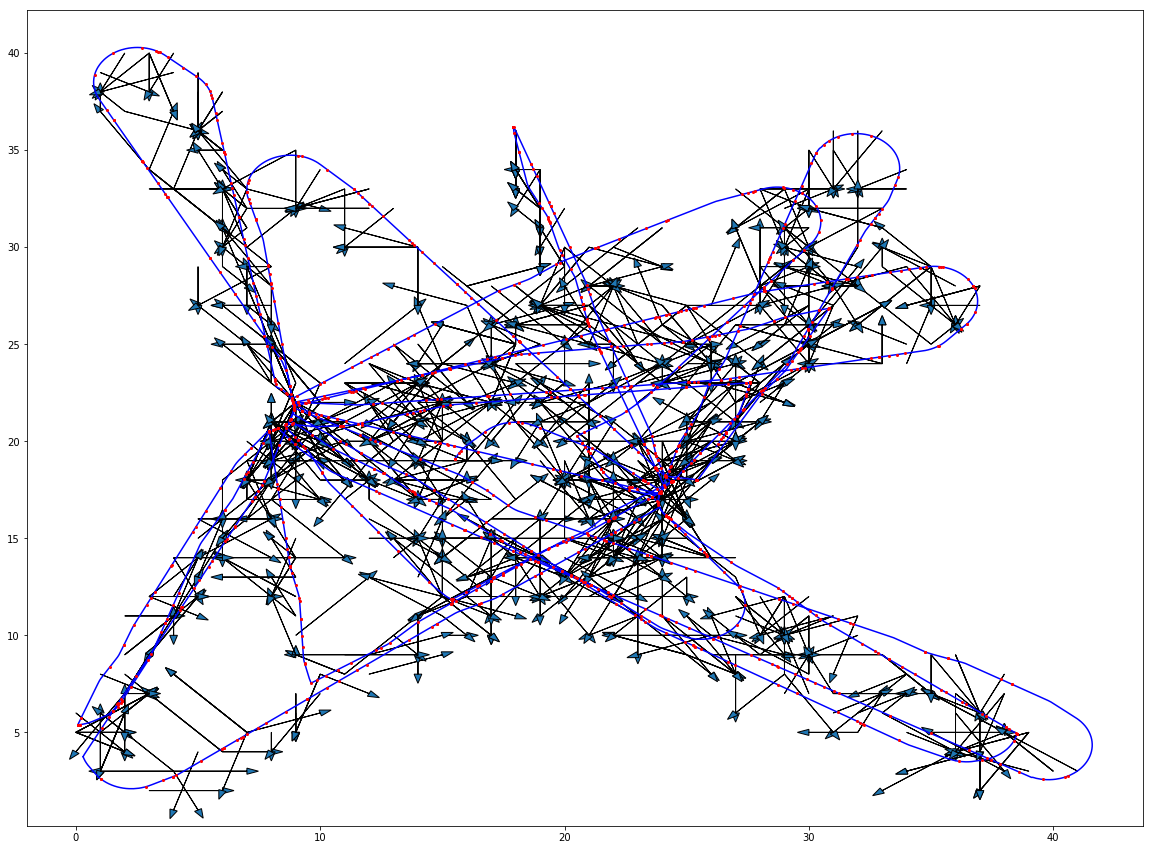

In [111]:
plt.rcParams['figure.figsize'] = [20,15]
plt.plot(xyPos[:,0]/2,xyPos[:,1]/2, color='b')
plt.plot(XYspkT[:,0]/2,XYspkT[:,1]/2, '.', color='r', markersize=4)
for index, row in df.iterrows():
    plt.arrow(row['X'],row['Y'],row['Xdif Predicted'],row['Ydif Predicted'], head_width=3*width)

In [112]:
for i in almost_all:
    print(type(i[1]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.fl

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.fl